In [1]:
import sys,os
import h5py

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 18})

from scipy.stats import norm
from scipy.optimize import curve_fit

sys.path.append('/home/nexus-admin/NEXUS_RF/BackendTools')
import MB_equations as MBe
import TimestreamHelperFunctions as Thf

In [2]:
## MB Results come from fitting a temperature scan at a specified RF power
use_nexus_MBvals = False

if use_nexus_MBvals:
    ## As measured in NEXUS
    MB_fit_vals = np.array([4.24216+9.75e-6, 
                            0.177  ,
                            0.0125 ,
                            4.1e7  ]) ## [ F0 [GHz] , Delta [meV] , alpha , Qi0 ]
else:
    ## As measured on Caltech sister device (https://arxiv.org/pdf/2111.08064.pdf)
    MB_fit_vals = np.array([4.24201000, 
                            0.184     ,
                            0.03801   ,
                            4.05538e5 ]) ## [ F0 [GHz] , Delta [meV] , alpha , Qi0 ]
    
## How much attenuation is in the lines before the chip
line_atten_dB = 56.5

## Define the MB parameters
alpha = MB_fit_vals[2]
Delta = MB_fit_vals[1] ## meV
D     = Delta*1e-3     ##  eV

## Temperature of the device
T = 10.0e-3 ## K

## Superconducting volume per resonator
V = 3e4 ## um^3

## Energy of the incident photons
hv = 2.61 ## eV

## Resonators per device
M_NEXUS    = 1

In [3]:
datapath = '/data/USRP_Laser_Data'
series   = "20230215_101743"
f_name   = series+"_OF_pulse_amps.h5"
f_path   = os.path.join(datapath,f_name)

data_df = pd.read_hdf(f_path,"data")
fits_df = pd.read_hdf(f_path,"fit")
fit_errs_df = pd.read_hdf(f_path,"fit err")
sums_df = pd.read_hdf(f_path,"sum")
maxs_df = pd.read_hdf(f_path,"max")
sums_errs_df = pd.read_hdf(f_path,"sum err")
maxs_errs_df = pd.read_hdf(f_path,"max err")

b7_res  = pd.read_hdf(f_path,"b7_res")["b7_res"][0]
r_fit   = pd.read_hdf(f_path,"r_fit")["r_fit"][0]
print("Baseline resolution:", b7_res*100, "% of tallest peak")
print("Responsivity per photon:", r_fit, "df/f per photon")

Baseline resolution: 0.7785046802477616 % of tallest peak
Responsivity per photon: 6.187766079809401e-05 df/f per photon


In [4]:
fit_errs_df

,5.0,4.5,4.0,3.5,3.0,2.5,2.0
0,0.000020,0.000017,0.000019,0.000016,0.000013,0.000015,0.000011
1,0.000034,0.000030,0.000032,0.000027,0.000022,0.000026,0.000019


In [5]:
sum_file, dly_file, vna_file, nse_files, led_files = Thf.GetFiles(series, 
                                                        base_path=datapath,
                                                        sep_noise_laser=True,
                                                        verbose=False)

md, charFs, charZs = Thf.UnpackSummary(sum_file, verbose=False)
rf_power = md['power']   ## dBm at USRP
tx_gain  = md['tx_gain'] ## dB
f        = charFs[1]   ## MHz
print("RF Power at USRP:", rf_power+tx_gain-line_atten_dB, "dBm")

RF Power at USRP: -72.5 dBm


In [6]:
k2 = MBe.kappa_2(T, f*1e6, D)[0] *1e6*1e6*1e6

print("Readout Power:", rf_power+tx_gain-line_atten_dB, "dBm")
print("Readout Freq.:", f[0] , "MHz")
print("Device Temp.: ", T*1e3, "mK")
print("==============================")
print("alpha: ", alpha*100, "%")
print("Delta: ", Delta    , "meV")
print("V:     ", V        , "um^3")
print("k2:    ", k2       , "um^3")

Readout Power: -72.5 dBm
Readout Freq.: 4241.97901 MHz
Device Temp.:  10.0 mK
alpha:  3.801 %
Delta:  0.184 meV
V:      30000.0 um^3
k2:     3.9131640517538905e-07 um^3


In [7]:
s_df_NEXUS = 4.65e-7

mu_amplitdue_dff = np.array([
    s_df_NEXUS,    ## 5.0 V
    3.8044e-7,     ## 4.5 V
    2.9523e-7,     ## 4.0 V
    2.0400e-7,     ## 3.5 V
    1.0354e-7,     ## 3.0 V
    0.1127e-7,     ## 2.5 V
])

In [8]:
## Baseline resolutions
sig_qp  = 2 * b7_res * s_df_NEXUS / (alpha*k2)
sig_abs = sig_qp * V * D

print("QP resolution:",sig_qp,"um^-3")
print("Absorbed energy resolution:",sig_abs,"eV")

QP resolution: 0.4867637761361676 um^-3
Absorbed energy resolution: 2.6869360442716452 eV


In [9]:
## Energy resolution from fit
sig_dep = b7_res / (r_fit/hv)
print("Deposited energy resolution:",sig_dep,"eV")

## Eta phonon
eta_ph_val = sig_abs / sig_dep
print("Eta phonon:",eta_ph_val*100,"%")

Deposited energy resolution: 328.37330778820353 eV
Eta phonon: 0.8182565332029617 %


In [10]:
#### =============================================================== ####
## Try to calculate eta_ph from largest pulse amplitude distribution
## This does not use the fit value
#### =============================================================== ####

## Calculate qp density corresponding to a specific pulse height
n_qp = 2 * s_df_NEXUS / (alpha *k2)
print("n_qp:", 2 * mu_amplitdue_dff / (alpha *k2))

## Calculate how many photons correpsond to that qp density (x 1/eta_ph)
N_gamma = n_qp * M_NEXUS * V * D / (hv)

## Calculate photon shot noise prefactor (x sqrt(eta_ph))
sigma_LED_df = np.sqrt( (1/M_NEXUS) * (alpha/2.) * (hv/D) * (k2/V) * s_df_NEXUS  )

## Set a limit on eta_ph (x f^2)
ratio = np.power( s_df_NEXUS / sigma_LED_df ,2)
print("eta_ph =",ratio,"f")

print("Sig at highest mu:",fits_df["5.0"][1],2)
frac = np.sqrt( np.power(fits_df["5.0"][1],2) - np.power(b7_res,2) )

eta_ph_val_prime = ratio*np.power( frac ,2)

print("For f="+str(100.0*frac)+"%, eta_ph =", eta_ph_val)
    
## Average energy per pulse
E = (2/(alpha*k2)) * mu_amplitdue_dff * (V*Delta/1e3) / eta_ph_val_prime
print(E/1e3,"keV")

## Average number of photons
print(np.round(E/hv),"photons")

n_qp: [62.52547846 51.15525382 39.69762797 27.43053248 13.92233987  1.51540246]
eta_ph = 132.2377935185562 f
Sig at highest mu: 0.010654274943526441 2
For f=0.7273693755959786%, eta_ph = 0.008182565332029617
[49.33219997 40.36116593 31.3211729  21.64251354 10.98463653  1.19564278] keV
[18901. 15464. 12000.  8292.  4209.   458.] photons


In [11]:
def frac_to_E_keV(frac):
    return (2/(alpha*k2)) * (frac*s_df_NEXUS) * (V*Delta/1e3) / eta_ph_val / 1e3

def E_keV_to_photon(E_keV):
    return E_keV*1e3/hv

print(E_keV_to_photon(frac_to_E_keV(1.0)))

16160.921196794861


In [12]:
keys = np.array(data_df.keys())
voltages = keys.astype(float)

In [13]:
cmap  = plt.get_cmap('OrRd')
nbins = 20

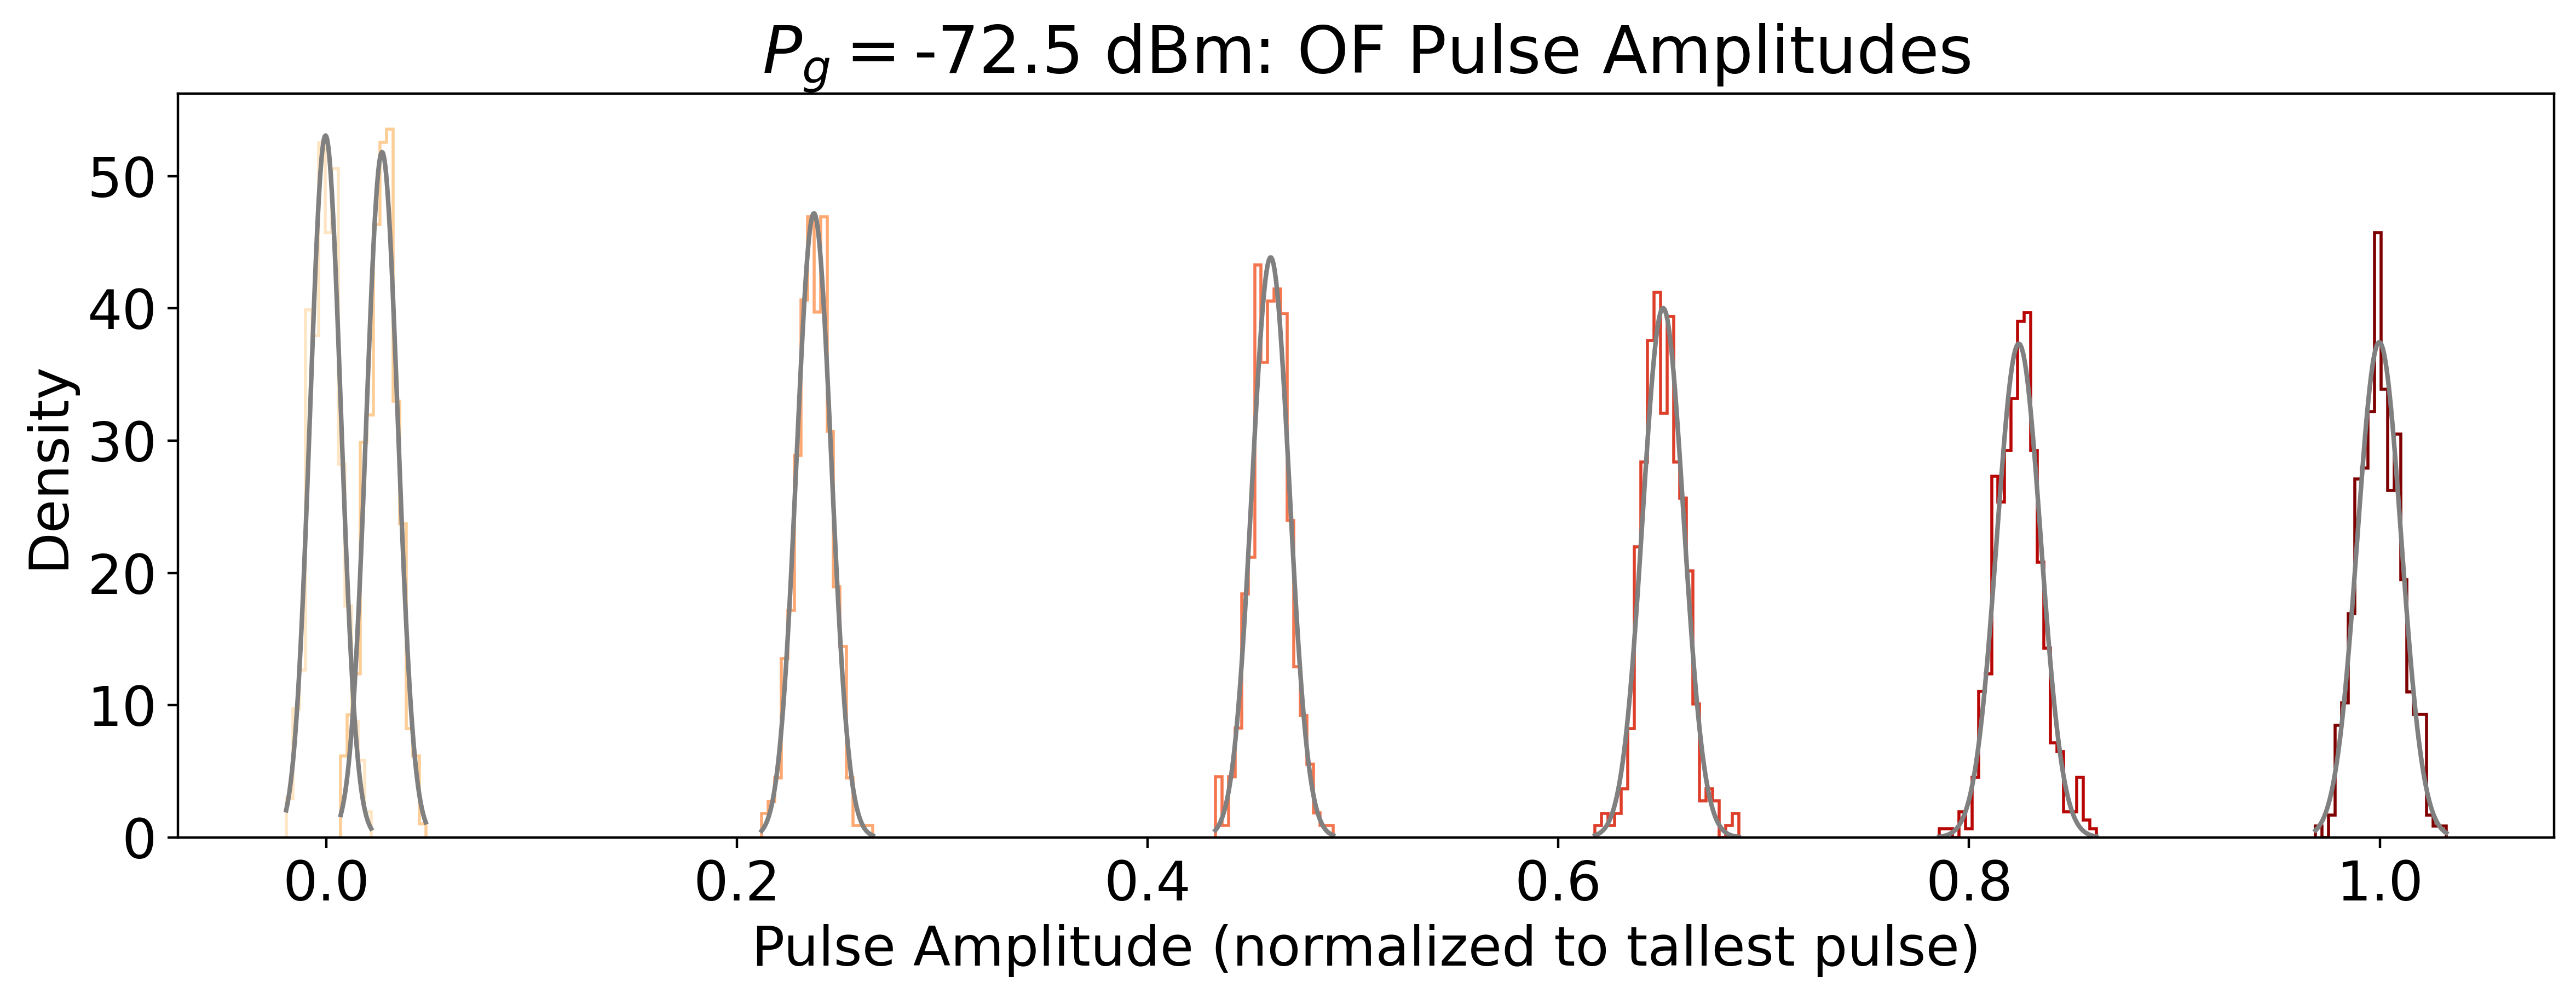

In [14]:
plt.figure(figsize=(14,4.5),dpi=400)
ax0 = plt.gca()

## Loop over the voltages
for i in np.arange(len(keys)):
    data = data_df[keys[i]]
    data = data[data>-998]
    
    mu,sig = fits_df[keys[i]]
    
    color = cmap( (voltages[i]-1.5) / (np.max(voltages)-1.5) )
    
    if i == 0:
        n, bins, patches = plt.hist(data,bins=nbins,fill=False,histtype='step',label='radians',color=color,density=1.0)
        bin_width = bins[1]-bins[0]
    else:
        n, bins, patches = plt.hist(data,bins=np.arange(min(data), max(data) + bin_width, bin_width),fill=False,histtype='step',color=color,density=1.0)

    plt.plot(np.linspace(bins[0],bins[-1],100),
             norm.pdf(np.linspace(bins[0],bins[-1],100),mu,sig),
             c='gray')

ax0.set_xlabel('Pulse Amplitude (normalized to tallest pulse)')
ax0.set_ylabel('Density')
ax0.set_title(r'$P_g=$'+str(rf_power+tx_gain-line_atten_dB)+' dBm: OF Pulse Amplitudes')
if False:
    ylim = ax0.get_ylim()
    ax0.set_yscale('log')
    ax0.set_ylim([1e0,ylim[1]])

Text(0.5, 0, 'Number of Photons')

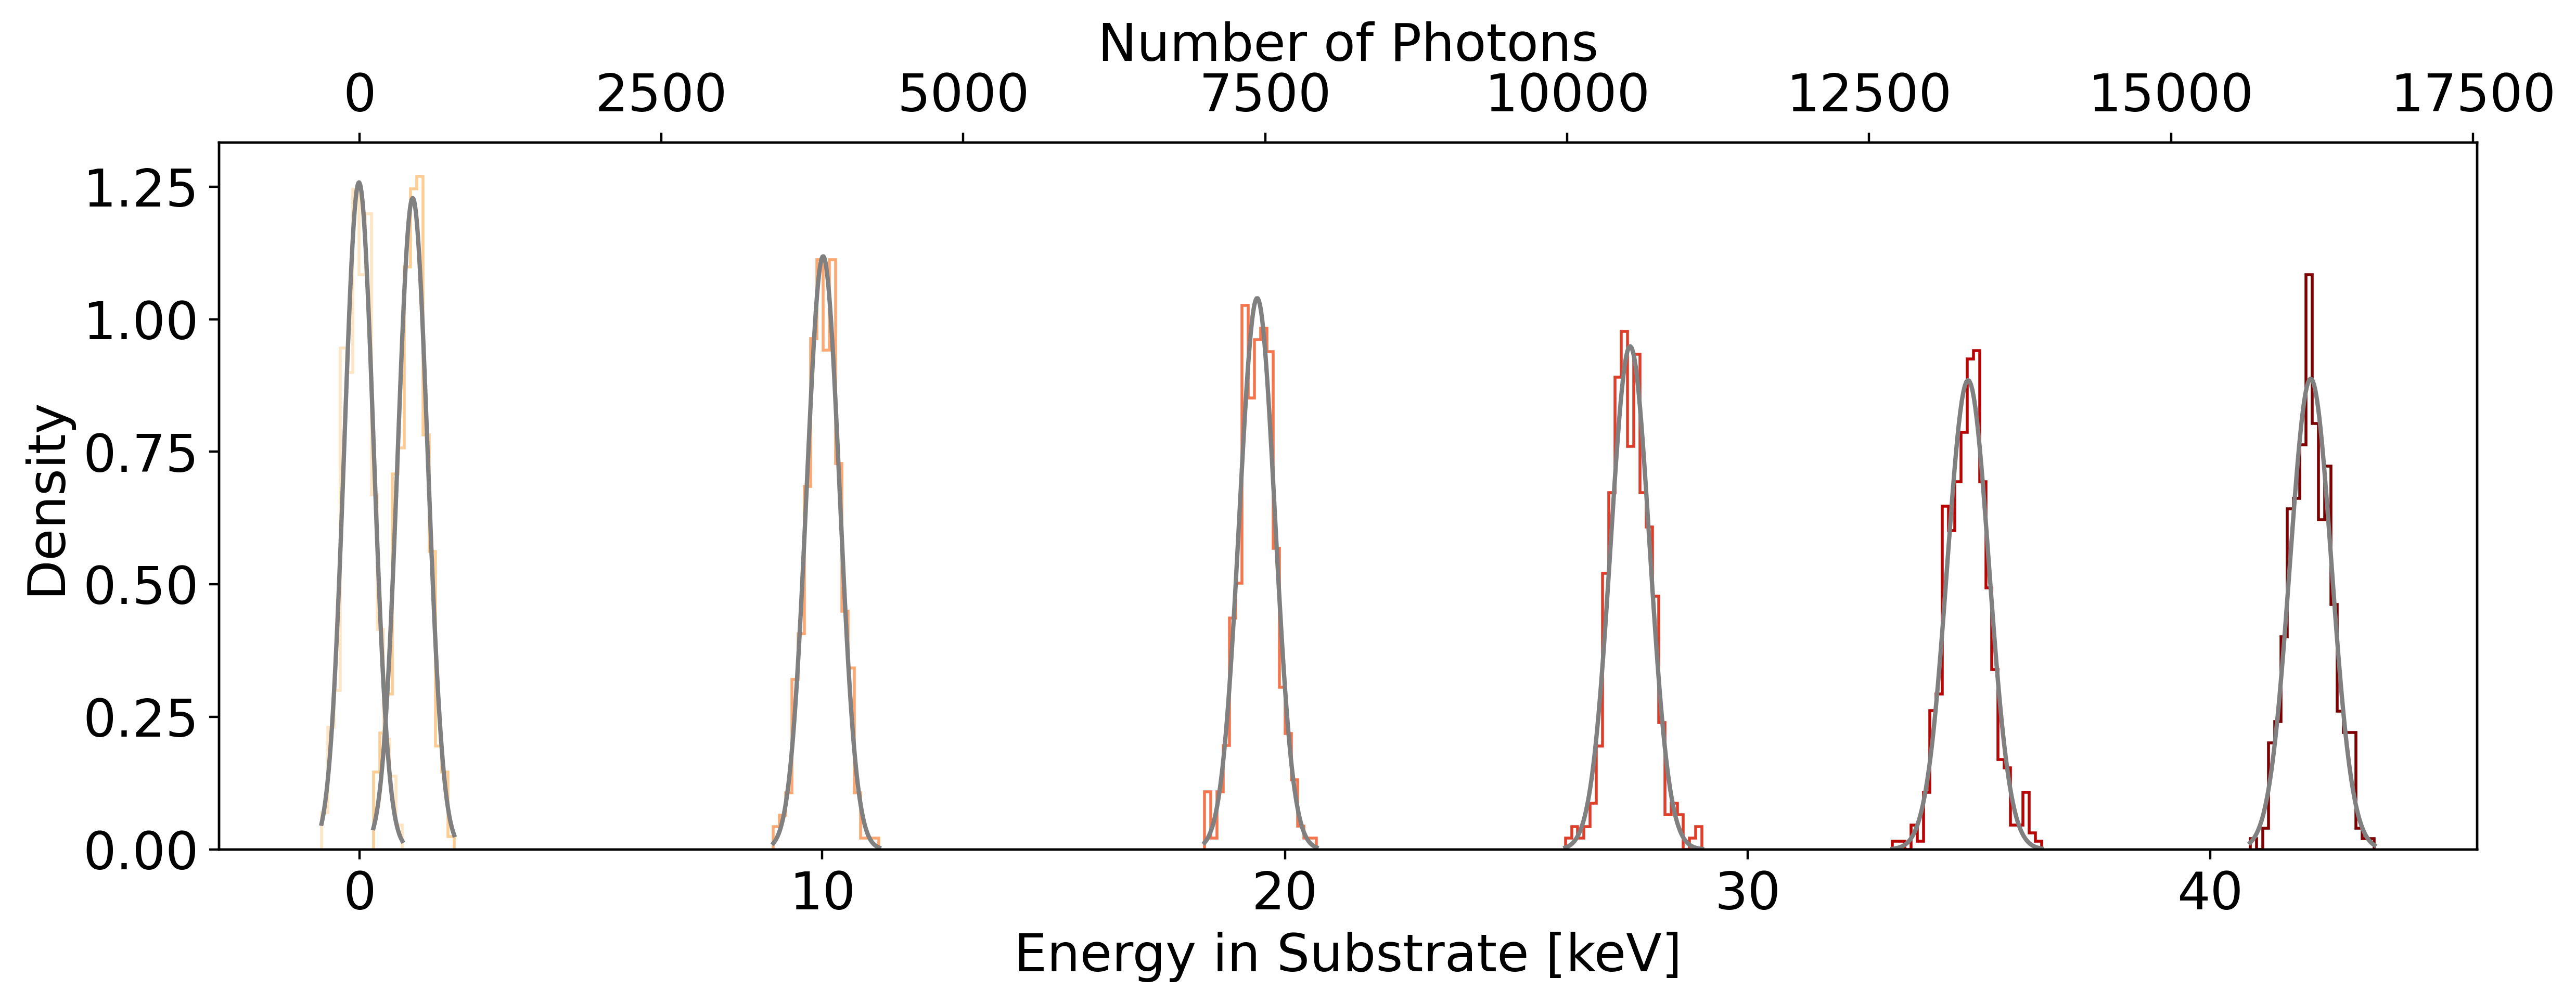

In [15]:
plt.figure(figsize=(14,4.5),dpi=400)
ax0 = plt.gca()

## Loop over the voltages
for i in np.arange(len(keys)):
    data = data_df[keys[i]]
    data = data[data>-998]
    data = frac_to_E_keV(data)
    
    mu,sig = fits_df[keys[i]]
    
    mu = frac_to_E_keV(mu)
    sig = frac_to_E_keV(sig)
    
    color = cmap( (voltages[i]-1.5) / (np.max(voltages)-1.5) )
    
    if i == 0:
        n, bins, patches = plt.hist(data,bins=nbins,fill=False,histtype='step',label='radians',color=color,density=1.0)
        bin_width = bins[1]-bins[0]
    else:
        n, bins, patches = plt.hist(data,bins=np.arange(min(data), max(data) + bin_width, bin_width),fill=False,histtype='step',color=color,density=1.0)

    plt.plot(np.linspace(bins[0],bins[-1],100),
             norm.pdf(np.linspace(bins[0],bins[-1],100),mu,sig),
             c='gray')

ax0.set_xlabel('Energy in Substrate [keV]')
ax0.set_ylabel('Density')
if False:
    ylim = ax0.get_ylim()
    ax0.set_yscale('log')
    ax0.set_ylim([1e0,ylim[1]])
    
ax1 = ax0.twiny()
ax1.set_xlim(E_keV_to_photon(np.array(ax0.get_xlim())))
ax1.set_xlabel("Number of Photons")

<ipython-input-26-5edb834b3b9d>:56: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigma_0**2 + (mu)*r)


[7.54873138e-03 6.18776608e-05]
energy resolution estimate is: 318.40552230385236
0.31393371890271715
0.2844686402328042
0.32726410267070183
0.2946537626958479
0.26390992864230445
0.3436708942853853
0.2562482434801435


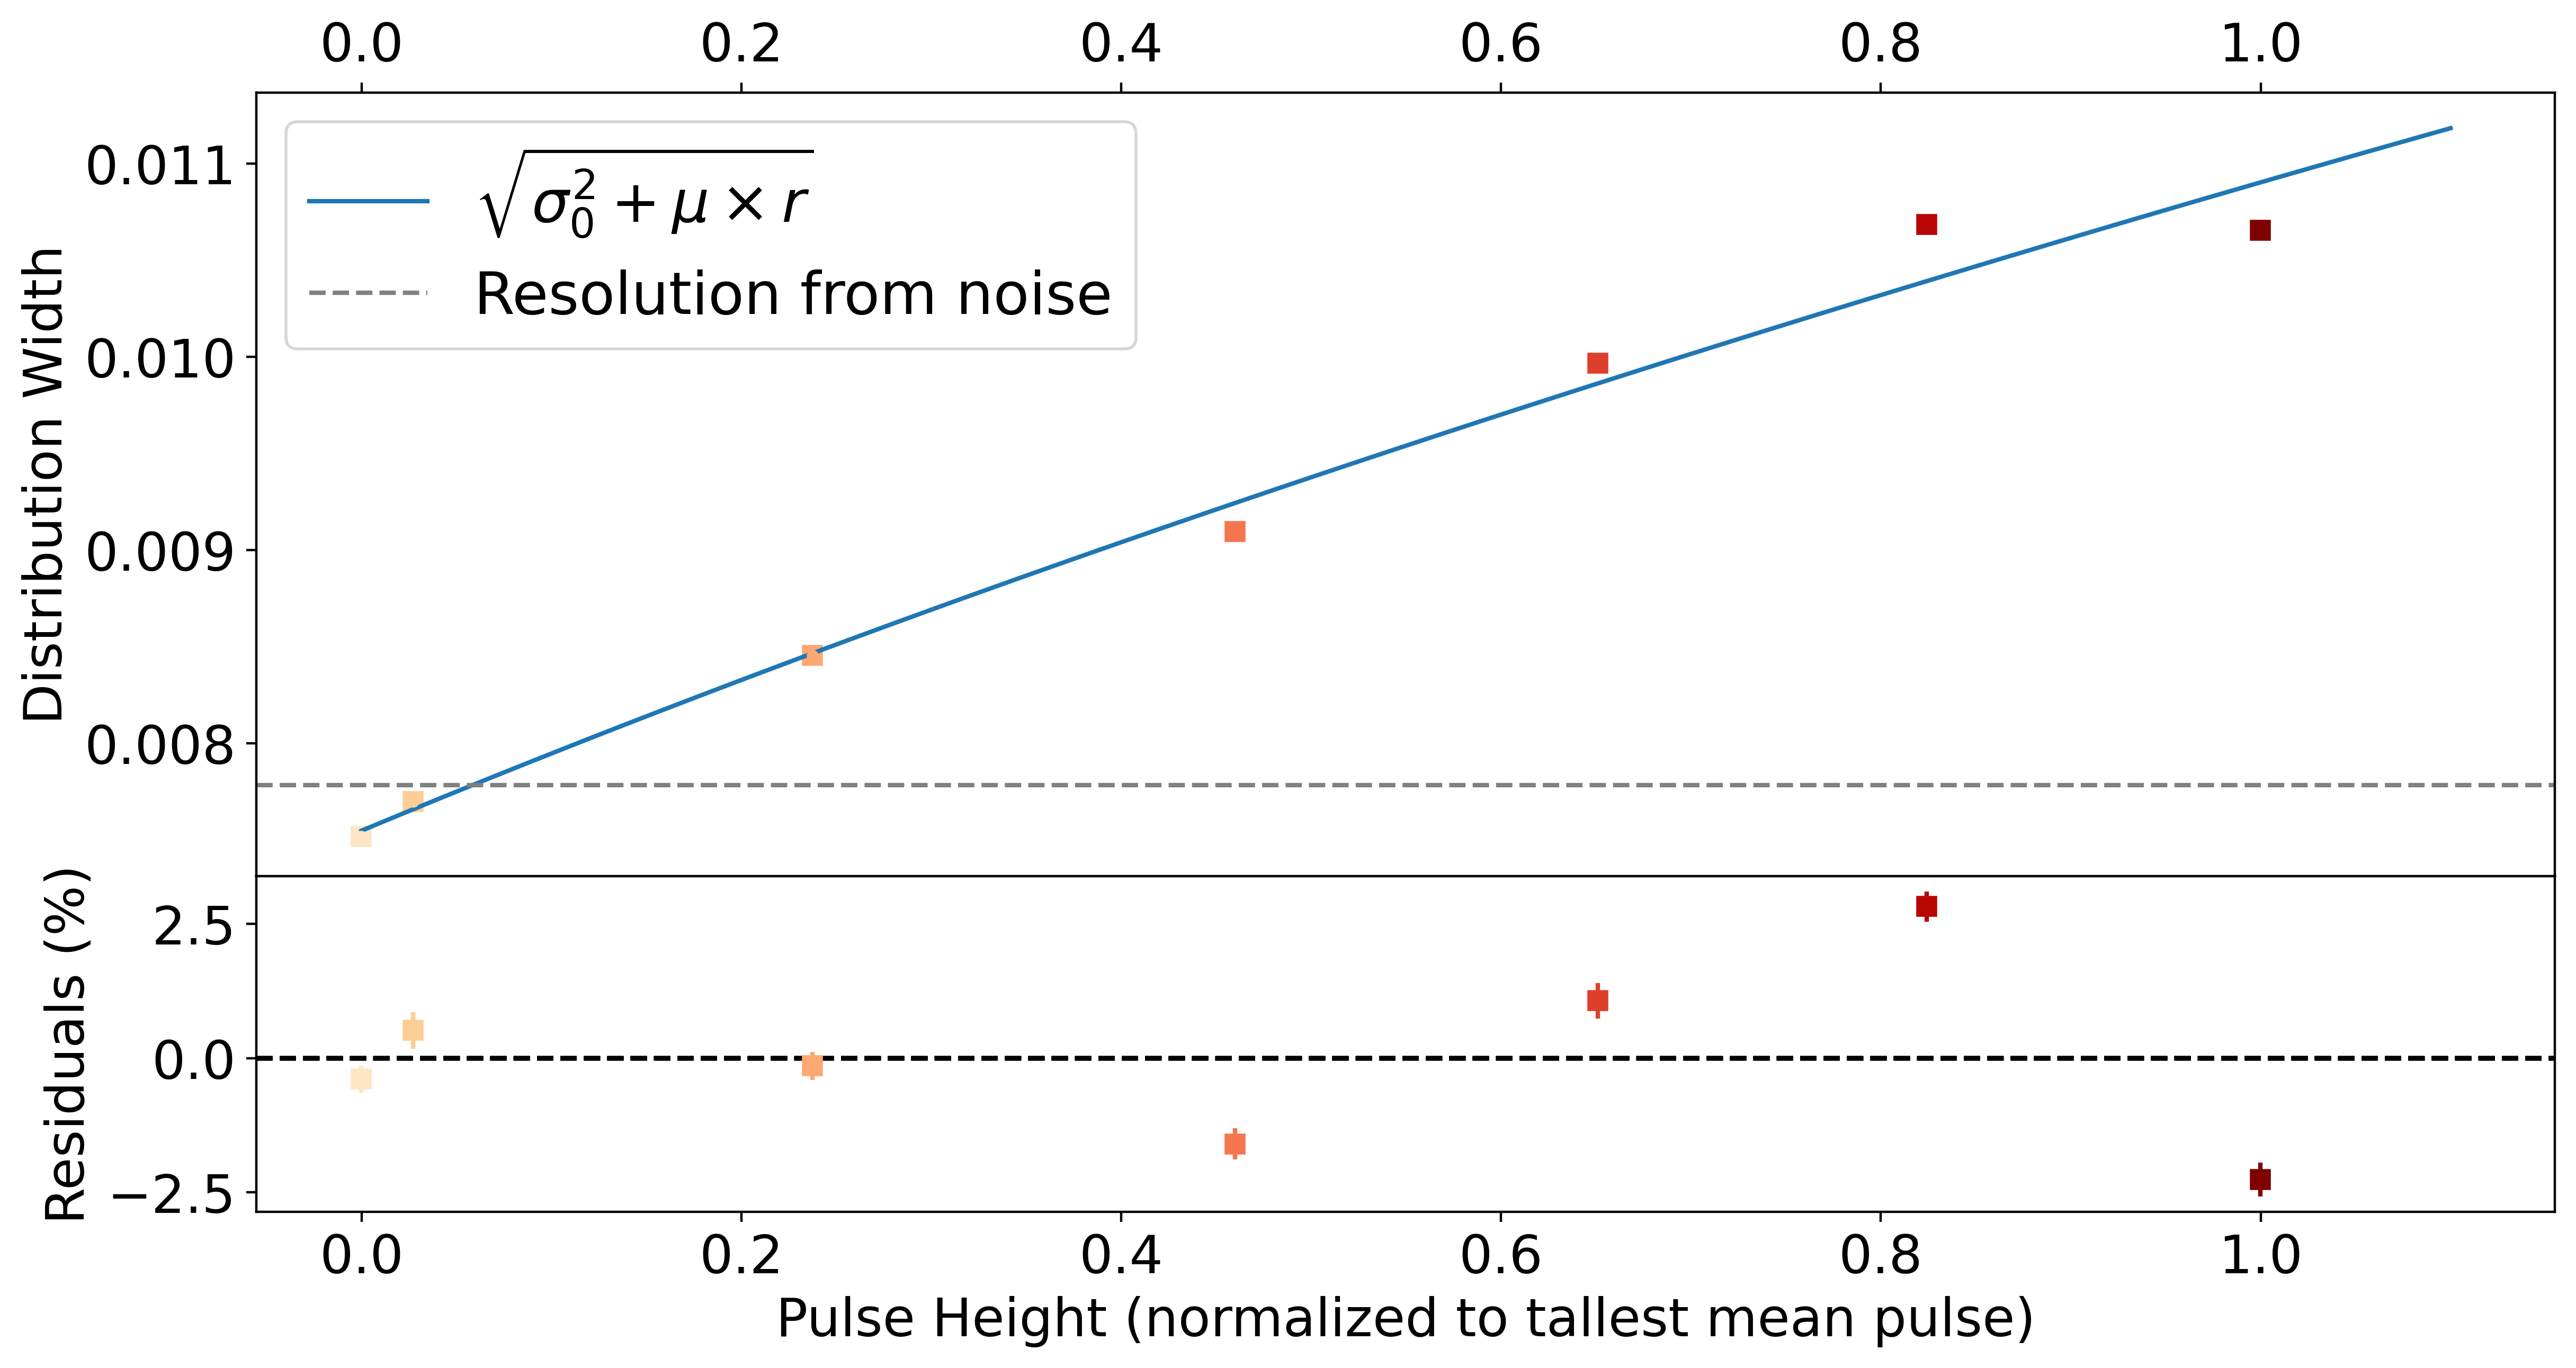

In [26]:
fig = plt.figure(figsize=(14,7),dpi=400)

# Define the grid
gs = GridSpec(2, 1, height_ratios=[7, 3])
gs.update(wspace=0.025, hspace=0.00) 

# Define the main plot
ax2 = fig.add_subplot(gs[0])

# Define the residual plots
ax2b = fig.add_subplot(gs[1], sharex=ax2)

# Turn off the axes for the main plot
# ax2.spines['bottom'].set_visible(False)
# ax2.xaxis.set_ticks_position('top')
ax2.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
# ax2.yaxis.set_ticks([])

## Set the axis labels
ax2b.set_xlabel('Pulse Height (normalized to tallest mean pulse)')
ax2.set_ylabel('Distribution Width')
ax2b.set_ylabel('Residuals (%)')

all_mus_raw  = np.zeros(len(keys))
all_sigs_raw = np.zeros(len(keys))

## Loop over the voltages
for i in np.arange(len(keys)):
    data = data_df[keys[i]]
    data = data[data>-998]
    data = frac_to_E_keV(data)
    
    mu,sig = fits_df[keys[i]]
    mu_err,sig_err = fit_errs_df[keys[i]]
    mu_sum,sigma_sum = sums_df[keys[i]]
    mu_max,sigma_max = maxs_df[keys[i]]
    all_mus_raw[i]   = mu
    all_sigs_raw[i]  = sig
    
    color = cmap( (voltages[i]-1.5) / (np.max(voltages)-1.5) )
    
    if i == 0:
        label1 = None#'Triggering on signal'
        label2 = 'Triggering on noise'
    else:
        label1 = None
        label2 = None
    err_scale = 1
    ax2.errorbar(mu,sig,xerr=err_scale*mu_err,yerr=err_scale*sig_err,
                 color=color,ls=None,marker='.')
    ax2.plot(mu,sig,color=color,ls=None,marker='s',label=label1)
#     ax2.plot(mu_sum,        sigma_sum,        color=color,ls=None,marker='s',label=label2,markersize=4,markeredgecolor='k')

def sig(mu,sigma_0,r):
#     return np.sqrt(b7_res**2 + (mu)*r)
    return np.sqrt(sigma_0**2 + (mu)*r)

p0 = [1e-1,1e-2]
f_fit_vals,_ = curve_fit(sig,all_mus_raw,all_sigs_raw,p0)
print(f_fit_vals)

# sigma_0_E_pub = abs(b7_res)/(f_fit_vals[1]/hv)
sigma_0_E_pub = abs(f_fit_vals[0])/(f_fit_vals[1]/hv)

print('energy resolution estimate is: ' + str(sigma_0_E_pub))

mu_plot = np.linspace(0,1.1,100)
sigma_s = sig(mu_plot,*f_fit_vals)

# ax2.plot(all_mus_raw,all_sigs_raw,ls=None)
ax2.plot(mu_plot,sigma_s,ls=None,label=r'$\sqrt{ \sigma_0^2 + \mu \times r }$')
# ax2.axhline(y=sigma_0_E_pub/1e3,color='grey')
ax2.axhline(y=b7_res,color='grey',label='Resolution from noise',ls='--')
# ax2.axhline(y=f_fit_vals[0],color='grey',label='Resolution from fit')
ax2.legend(loc='best',fontsize=20)

for jj in np.arange(len(keys)):
    xval = fits_df[keys[jj]][0]
    yval = fits_df[keys[jj]][1]
    xerr = fit_errs_df[keys[jj]][0]
    yerr = fit_errs_df[keys[jj]][1]
#     print(yval, yerr)
    fval = sig(xval, *f_fit_vals)
    yval = 100.0 * (yval-fval)/fval
    yerr = 100.0 * yerr/fval
    print(yerr)
    colr = cmap( (voltages[jj]-1.5) / (np.max(voltages)-1.5) )
    ax2b.errorbar(xval,yval,xerr=xerr,yerr=yerr,color=colr,marker='s',)
    ax2b.axhline(y=0,color='k',ls='--')

# fig.subplots_adjust(left=0.13, right=0.92, top=0.91, bottom=0.12)

energy resolution estimate is: 318.40552230385236


<ipython-input-28-95cea2d996c4>:62: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigma_0**2 + mu*r)


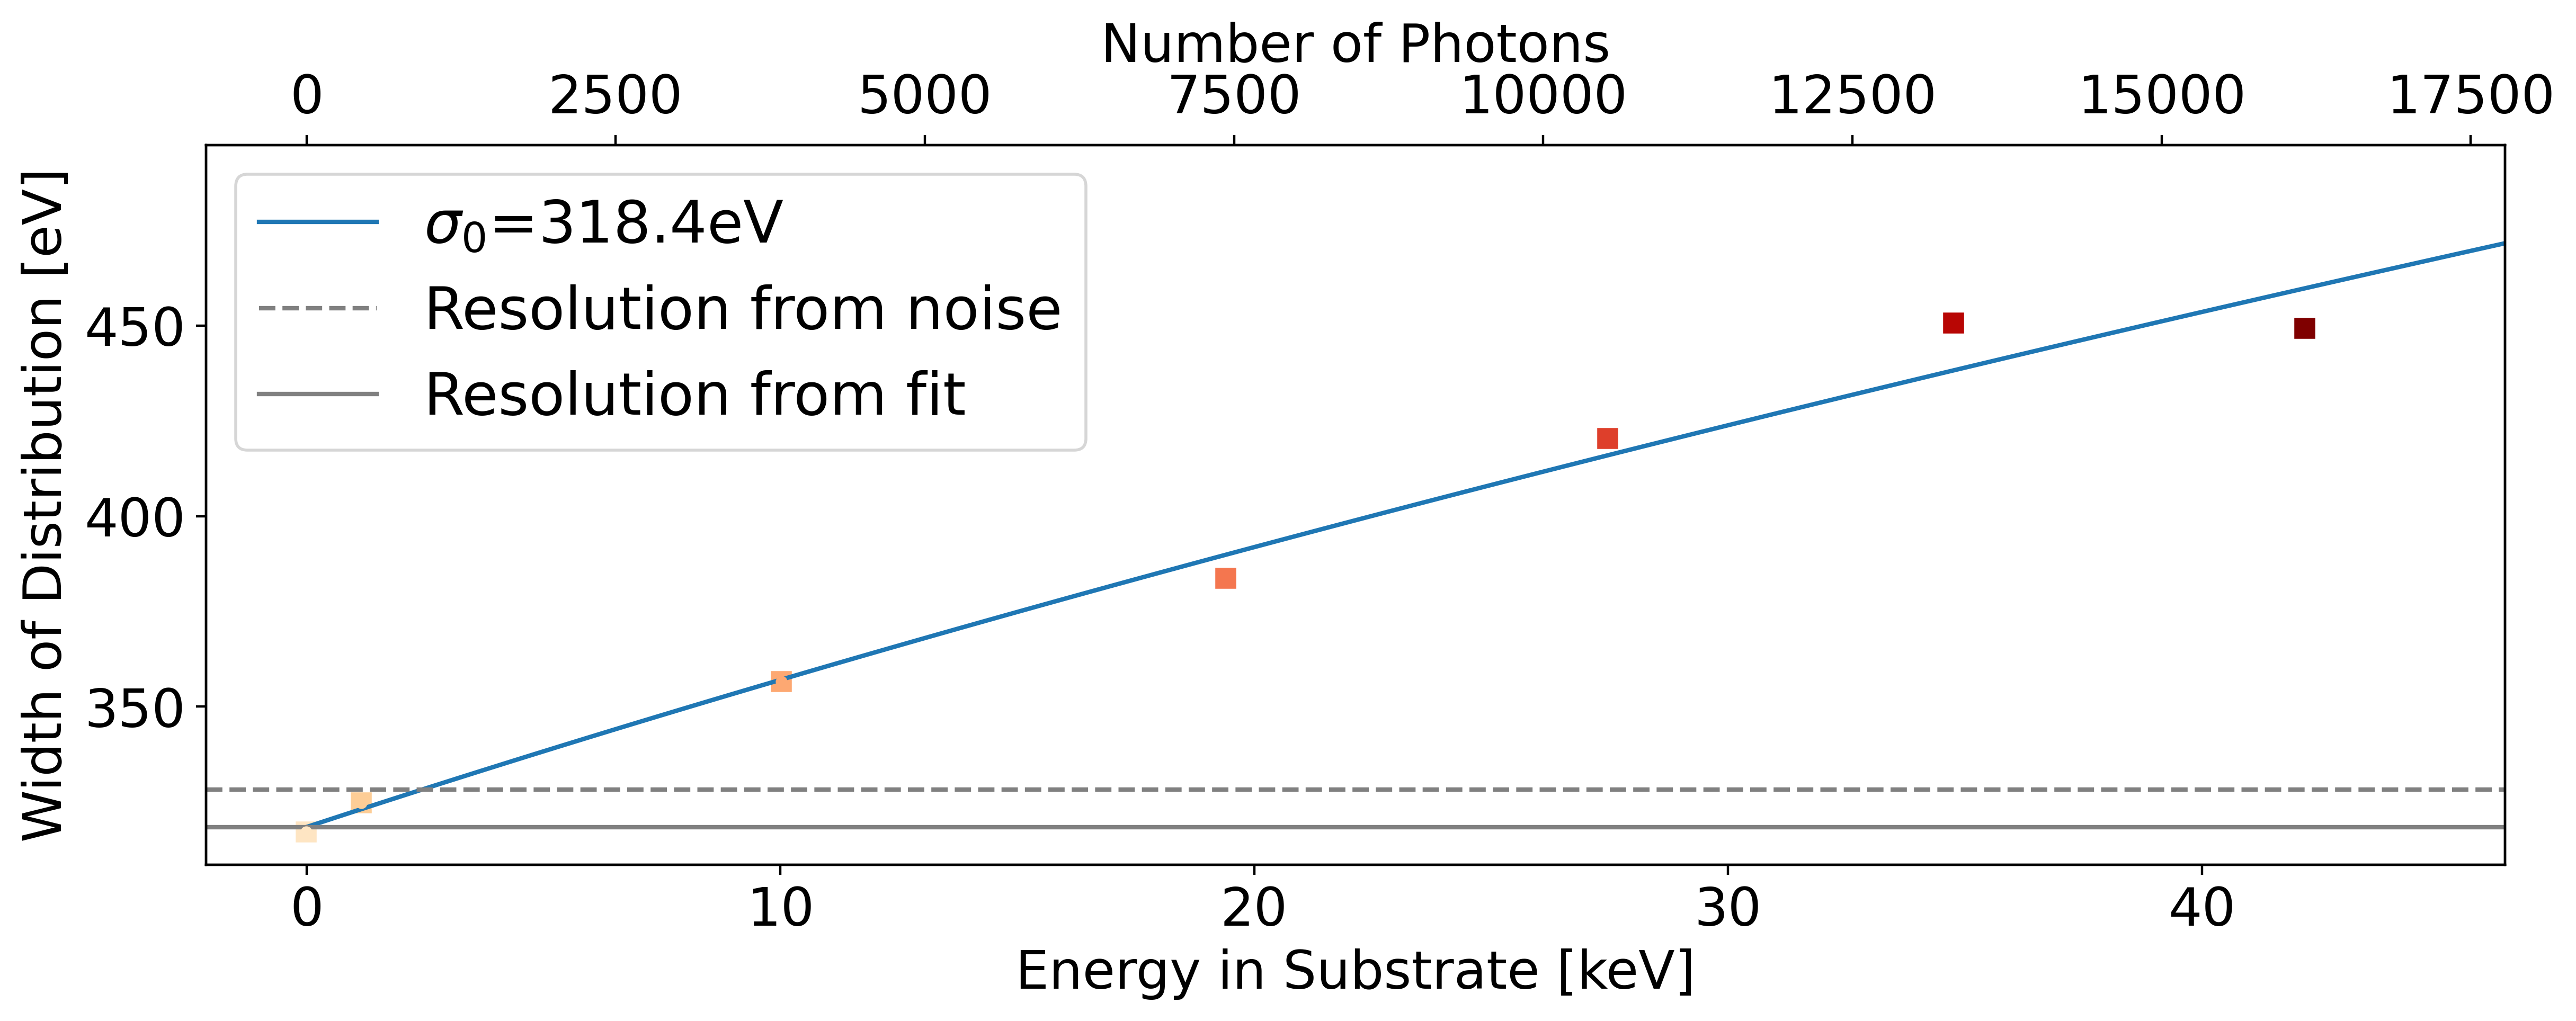

In [28]:
plt.figure(figsize=(14,4.5),dpi=400)
ax2 = plt.gca()

all_mus_raw  = np.zeros(len(keys))
all_sigs_raw = np.zeros(len(keys))

all_mus_df  = np.zeros(len(keys))
all_sigs_df = np.zeros(len(keys))

## Loop over the voltages
for i in np.arange(len(keys)):
    data = data_df[keys[i]]
    data = data[data>-998]
    data = frac_to_E_keV(data)
    
    mu,sig = fits_df[keys[i]]
    mu_err,sig_err = fit_errs_df[keys[i]]
    mu_sum,sigma_sum = sums_df[keys[i]]
    mu_max,sigma_max = maxs_df[keys[i]]
    all_mus_raw[i]   = mu
    all_sigs_raw[i]  = sig
    all_mus_df[i]    = mu * s_df_NEXUS
    all_sigs_df[i]   = sig * s_df_NEXUS
    
    mu = frac_to_E_keV(mu)
    sig = frac_to_E_keV(sig)
    
    mu_err = frac_to_E_keV(mu_err)
    sig_err = frac_to_E_keV(sig_err)
    
    mu_sum = frac_to_E_keV(mu_sum)
    sigma_sum = frac_to_E_keV(sigma_sum)
    
    mu_max = frac_to_E_keV(mu_max)
    sigma_max = frac_to_E_keV(sigma_max)
    
    color = cmap( (voltages[i]-1.5) / (np.max(voltages)-1.5) )
    
    if i == 0:
        label1 = None # 'triggering on signal'
        label2 = None # 'triggering on noise'
    else:
        label1 = None
        label2 = None
    err_scale = 1
    plt.errorbar(mu,sig*1e3,xerr=err_scale*mu_err,yerr=err_scale*sig_err,
                 color=color,ls=None,marker='.')
    plt.plot(mu,sig*1e3,color=color,ls=None,marker='s',label=label1)
#     plt.plot(mu_sum,        sigma_sum,        color=color,ls=None,marker='s',label=label2,markersize=4,markeredgecolor='k')

ax2.set_xlabel('Energy in Substrate [keV]')
ax2.set_ylabel('Width of Distribution [eV]')
xlims = ax2.get_xlim()
ax2.set_xlim([xlims[0],1.1*frac_to_E_keV(1.0)])

ax3 = ax2.twiny()
ax3.set_xlim(E_keV_to_photon(np.array(ax2.get_xlim())))
ax3.set_xlabel("Number of Photons")

def sig(mu,sigma_0,r):
#     return np.sqrt(b7_res**2 + mu*r)
    return np.sqrt(sigma_0**2 + mu*r)

p0 = [1e-1,1e-2]
f_fit_vals,_ = curve_fit(sig,all_mus_raw,all_sigs_raw,p0)

# sigma_0_E_pub = abs(b7_res)/(f_fit_vals[1]/hv)
sigma_0_E_pub = abs(f_fit_vals[0])/(f_fit_vals[1]/hv)

print('energy resolution estimate is: ' + str(sigma_0_E_pub))

mu_plot = np.linspace(0,1.25,100)
sigma_s = frac_to_E_keV(sig(mu_plot,*f_fit_vals))
mu_plot = frac_to_E_keV(mu_plot)

# ax2.plot(all_mus_raw,all_sigs_raw,ls=None)
ax2.plot(mu_plot,sigma_s*1e3,label='$\sigma_0$='+str(round(sigma_0_E_pub,1))+'eV',ls=None)
# ax2.axhline(y=sigma_0_E_pub/1e3,color='grey')
ax2.axhline(y=b7_res*frac_to_E_keV(np.max(all_mus_raw))*1e3,color='grey',label='Resolution from noise', ls='--')
ax2.axhline(y=f_fit_vals[0]*frac_to_E_keV(np.max(all_mus_raw))*1e3,color='grey',label='Resolution from fit')
ax2.legend(loc='best',fontsize=20)